#  Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'trrain.csv'),low_memory=False)
df.dropna(how='all')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,28cffd1d2ba52a18,If I were to take the ill-advised action you a...,0,0,0,0,0,0
1,28d0251654b4925d,Thats cos Im a schitzophrenic TOAT. But ure ju...,1,0,0,0,0,0
2,28d346cc8be778ed,Admin Please note this edit https://en.wikiped...,0,0,0,0,0,0
3,28d452e1bc5a252e,is \n\nDare I say Gogo Dodo is a wikihound?,0,0,0,0,0,0
4,28d507b975ff2fef,June 2014 (UTC)\n\nThanks. If you want to crea...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15472,28da49d589de1153,"Sock Puppet\nDefend yourself, why don't ya? ht...",0,0,0,0,0,0
15473,28da8a3204519328,Richard Stallman's Johnson \n\nWhat is your ob...,0,0,0,0,0,0
15474,28dada15b6657031,One Railway \nWhy don't we create another arti...,0,0,0,0,0,0
15475,28daf85d0436a11d,LOL. At least she doesn't have to be with you ...,0,0,0,0,0,0


In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,28cffd1d2ba52a18,If I were to take the ill-advised action you a...,0,0,0,0,0,0
1,28d0251654b4925d,Thats cos Im a schitzophrenic TOAT. But ure ju...,1,0,0,0,0,0
2,28d346cc8be778ed,Admin Please note this edit https://en.wikiped...,0,0,0,0,0,0
3,28d452e1bc5a252e,is \n\nDare I say Gogo Dodo is a wikihound?,0,0,0,0,0,0
4,28d507b975ff2fef,June 2014 (UTC)\n\nThanks. If you want to crea...,0,0,0,0,0,0


# Data Preprocessing

In [5]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.2.0
aiohttp                            3.8.3
aiosignal                          1.2.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              3.6.2
appdirs                            1.4.4
apyori                             1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      4.0.2
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 150000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(10000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create Sequential Model(LSTM,LSTM-CNN)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          4800032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=1, validation_data=val)

677/677 [==============================] - 699s 1s/step - loss: 0.1147 - val_loss: 0.0602


In [19]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

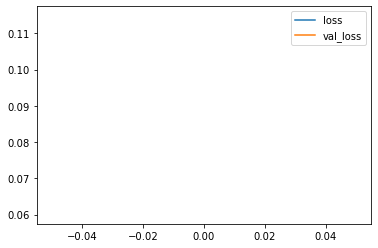

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#  Make Predictions

In [21]:
batch = test.as_numpy_iterator().next()

In [22]:
input_text = vectorizer('You freaking suck!')

In [23]:
model.predict(np.array([input_text]))

1/1 [==============================] - 2s 2s/step


array([[0.65986043, 0.07624056, 0.3867087 , 0.04631257, 0.389772  ,
        0.09283511]], dtype=float32)

In [24]:
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 0s 124ms/step


array([[0.65986043, 0.07624056, 0.3867087 , 0.04631257, 0.389772  ,
        0.09283511]], dtype=float32)

In [25]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [26]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [27]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 192ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
res.shape

(1, 6)

# Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 198ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8518518805503845, Recall:0.4522472023963928, Accuracy:0.40625


# Calculating Model Accuracy using Test-set¶
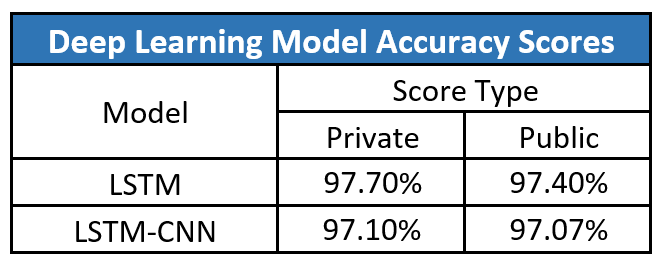

#  Test and Gradio

In [33]:
!pip install gradio jinja2

In [34]:
pip install typing_extensions

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install dataclasses

Note: you may need to restart the kernel to use updated packages.


In [36]:
import tensorflow as tf
from dataclasses import dataclass
import gradio as gr
from typing_extensions import dataclass_transform

In [37]:
model.save('toxicity.h5')

In [38]:
model = tf.keras.models.load_model('toxicity.h5')

In [39]:
input_str = vectorizer('hey i freaken hate you!')

In [40]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 1s/step


In [41]:
res

array([[0.49856797, 0.02932185, 0.24758278, 0.02540248, 0.24886408,
        0.05266301]], dtype=float32)

In [42]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [43]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\sashank\anaconda3\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\sashank\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\sashank\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\sashank\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [44]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://30c51bdc4fcbcd46.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x1df82725af0>,
 'http://127.0.0.1:7860/',
 'https://30c51bdc4fcbcd46.gradio.app')

1/1 [==============================] - 0s 150ms/step
